# Prepartions

In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import HuberRegressor
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
import matplotlib.dates as mdates
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor
import gc
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
df_final = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/The complete dataframe/df_final_cleaned_combined_2_endofmonth.csv")

df_final['Adj Close t+1'] = df_final.groupby("Symbol")["Adj Close"].shift(-1)

df_final = df_final.dropna(subset=['Adj Close t+1']).reset_index(drop=True)

df_final = df_final[df_final['1-month momentum'] != 0]

df_final['Date'] = pd.to_datetime(df_final['Date'])

df_final = df_final.sort_values(by='Date').reset_index(drop=True)

df_final = df_final[df_final['Adj Close t+1'] <= df_final["Adj Close t+1"].quantile(0.985)]



variables = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Market capitalization', 'Revenue', 'Earnings',
       'P/E ratio', 'P/B ratio', 'Operating Margin', 'EPS',
       'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
       'Cash on Hand', 'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size']

df_final[variables] = df_final[variables].replace([np.inf, -np.inf], np.nan)

non_negative_variables = [
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
    'Stock Splits', 'Market capitalization', 'Revenue', 'EPS',
    'Shares Outstanding', 'Total assets', 'Total liabilities', 'Total debt',
    'Cash on Hand', 'Net assets'
]

df_final[non_negative_variables] = df_final[non_negative_variables].applymap(lambda x: max(x, 0))


funda_cols = [
    'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio', 'P/B ratio',
    'Operating Margin', 'EPS', 'Shares Outstanding', 'Total assets',
    'Total liabilities', 'Total debt', 'Cash on Hand', 'Net assets'
]

df_final[funda_cols] = (
    df_final.groupby('Symbol')[funda_cols]
      .shift(12))

df_final = df_final.dropna(subset=variables).reset_index(drop=True)



In [3]:
df_final

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Sector,...,Cash on Hand,Net assets,1-month momentum,6-month momentum,12-month momentum,36-month momentum,Book-to-market,Size,Symbol,Adj Close t+1
0,1997-02-28,0.150670,0.150670,0.145089,0.145089,0.122524,121878400.0,0.0,0.0,Technology,...,1.740000e+09,0.000000e+00,-0.002828,0.006597,0.012723,0.102261,10.516756,0.000000,AAPL,0.137604
1,1997-02-28,6.937500,6.937500,6.812500,6.812500,2.242910,9400.0,0.0,0.0,Consumer Discretionary,...,4.700000e+06,8.849816e+07,-0.022543,0.019197,0.394677,1.072677,0.668527,18.906044,SGC,2.140023
2,1997-02-28,39.187500,39.312500,38.375000,39.312500,32.637779,494200.0,0.0,0.0,Finance,...,1.400000e+08,2.293864e+09,2.040556,13.065813,25.626753,3.814121,0.645497,22.474418,MTG,29.368822
3,1997-02-28,10.625000,10.937500,10.562500,10.875000,10.332757,159200.0,0.0,0.0,Technology,...,5.300000e+06,9.747199e+07,-1.425210,6.354053,6.057135,5.700832,0.062723,19.351977,NICE,9.738921
4,1997-02-28,31.500000,31.500000,30.687500,30.687500,9.806581,22000.0,0.0,0.0,Finance,...,6.967000e+07,0.000000e+00,1.078525,3.761210,6.900859,4.914822,0.355534,21.321768,MCY,9.791734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700452,2024-08-30,38.150002,38.590000,37.830002,38.580002,38.580002,539900.0,0.0,0.0,Utilities,...,2.700000e+08,3.020000e+09,-1.464996,3.577999,5.195873,-2.139236,0.021338,21.436014,WES,38.299999
700453,2024-08-30,30.900000,31.200001,30.209999,30.440001,30.440001,2364900.0,0.0,0.0,Consumer Discretionary,...,6.953566e+08,1.731511e+09,1.089708,0.321186,15.223827,30.727109,0.105255,22.685456,HTHT,29.340000
700454,2024-08-30,6.690000,6.880000,6.670000,6.860000,6.860000,4055300.0,0.0,0.0,Technology,...,3.700000e+08,5.990000e+09,0.120000,0.380000,-3.950000,13.850000,0.341980,21.832332,CLVT,6.550000
700455,2024-08-30,51.099998,51.250000,49.590000,50.919998,50.919998,1494400.0,0.0,0.0,Technology,...,3.700000e+08,1.760000e+09,-1.520000,14.780001,4.780000,-2.470000,-0.115780,20.748237,CLS,43.490002


# The sampling algorithm

In [26]:

def recursive_rolling_method(data, initial_date, date_column='Date', 
         train_period = 24, val_period = 24, test_period = 12, freq = 'months'):
    
                
    train_indices_list = []
    val_indices_list = []
    test_indices_list = []

    
    # Define initial interval
    start_train = initial_date
    end_train = start_train + relativedelta(**{freq: train_period})
    
    start_val = end_train + relativedelta(months=1)
    end_val = start_val + relativedelta(**{freq: val_period})
    
    start_test = end_val + relativedelta(months=1)
    end_test = start_test + relativedelta(**{freq: test_period})

    
    while start_test  < data[date_column].max():   
        cur_train_indices = list(data[(data[date_column] >= start_train) & 
                              (data[date_column] < end_train)].index)

        cur_val_indices = list(data[(data[date_column] >= start_val) & 
                                    (data[date_column] < end_val)].index)

        cur_test_indices = list(data[(data[date_column] >= start_test) & 
                                    (data[date_column] < end_test)].index)

        
        print("    Train period:",start_train, "-" , end_train, 
            " || Val period:",start_val, "-" , end_val, 
            " || Test period", start_test, "-", end_test,
            " || Train contains", len(cur_train_indices),
            " || Val contains", len(cur_val_indices) , 
            " || Test contains", len(cur_test_indices))

        train_indices_list.append(cur_train_indices)
        val_indices_list.append(cur_val_indices)
        test_indices_list.append(cur_test_indices)
        
        
        # Define next interval
        
        filler_unit = 1
        start_train = start_train + relativedelta(**{freq: filler_unit}) #  -  this only goes one period ahead for each interval, so they overlap
        
        # start_train = end_test
        end_train = start_train + relativedelta(**{freq: train_period})  
        
        start_val = end_train + relativedelta(months=1)
        end_val = start_val + relativedelta(**{freq: val_period})
            
        start_test = end_val + relativedelta(months=1)
        end_test = start_test + relativedelta(**{freq: test_period})

    # Ensure we have the same output as sklearn sampling packages, since we will use its regressors
    index_output = [(train,val,test) for train,val,test in zip(train_indices_list,val_indices_list,test_indices_list)]
    
    return index_output


In [96]:
# Create the top and bottom firms by market cap:

top_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nlargest(500)  
    .index 
)


df_top_500 = df_final[df_final['Symbol'].isin(top_symbols)].reset_index(drop=True)



bottom_symbols = (
    df_final.groupby('Symbol')['Market capitalization'].last() 
    .nsmallest(500)  
    .index 
)


df_bottom_500 = df_final[df_final['Symbol'].isin(bottom_symbols)].reset_index(drop=True)

In [6]:
df_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'Sector', 'Industry',
       'Market capitalization', 'Revenue', 'Earnings', 'P/E ratio',
       'P/B ratio', 'Operating Margin', 'EPS', 'Shares Outstanding',
       'Total assets', 'Total liabilities', 'Total debt', 'Cash on Hand',
       'Net assets', '1-month momentum', '6-month momentum',
       '12-month momentum', '36-month momentum', 'Book-to-market', 'Size',
       'Symbol', 'Adj Close t+1'],
      dtype='object')

# NN1 algorithm for all stocks

In [40]:

X = df_final[['Date'] + variables]
y = df_final["Adj Close t+1"]

X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min()

predictions = []
y_test_list = []
dates = []


for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index]

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]

    
    input_shape = [X_train.shape[1]]
    
    
    mean_train = X_train.mean(axis=0)
    std_train  = X_train.std(axis=0)
    
    X_train = (X_train-mean_train) / std_train
    X_val = (X_val-mean_train) / std_train
    X_test = (X_test-mean_train) / std_train
    
    
    
    model = tf.keras.Sequential([
 
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
    
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0, clipnorm=1.0, clipvalue=0.5), loss='mse')    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])
    
    preds = model.predict(X_test)
    preds = preds.ravel()


    predictions.append(preds)
    dates.append(X.loc[y_test.index, 'Date'])
    y_test_list.append(y_test)



    del X_train, y_train, X_val, y_val, model, preds
    gc.collect()

    print(f"Completed {split_num + 1} splits")

predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)

R2oos_NN1 = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos NN1:", R2oos_NN1)


    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 125811  || Val contains 60364  || Test contains 22228
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 131822  || Val contains 63246  || Test contains 22915
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 138129  || Val contains 66069  || Test contains 23302
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 145727  || Val contains 68275  || Test contains 24233
    

# NN1 algorithm for top 500 stocks

In [97]:

X = df_top_500[['Date'] + variables]
y = df_top_500['Adj Close t+1']

X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min()

predictions = []
y_test_list = []
dates = []


for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index]

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]

    
    input_shape = [X_train.shape[1]]
    
    
    mean_train = X_train.mean(axis=0)
    std_train  = X_train.std(axis=0)
    
    X_train = (X_train-mean_train) / std_train
    X_val = (X_val-mean_train) / std_train
    X_test = (X_test-mean_train) / std_train
    
    
    
    model = tf.keras.Sequential([
 
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
    
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0, clipnorm=1.0, clipvalue=0.5), loss='mse')    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])
    
    preds = model.predict(X_test)
    preds = preds.ravel()


    predictions.append(preds)
    dates.append(X.loc[y_test.index, 'Date'])
    y_test_list.append(y_test)



    del X_train, y_train, X_val, y_val, model, preds
    gc.collect()

    print(f"Completed {split_num + 1} splits")

predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)

R2oos_NN1_top = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos NN1 Top 500: ", R2oos_NN1_top)

    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 29361  || Val contains 13204  || Test contains 4636
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 30401  || Val contains 13524  || Test contains 4741
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 31579  || Val contains 13863  || Test contains 4803
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 32931  || Val contains 14151  || Test contains 4951
    Train pe

# NN1 algorithm for bottom 500 stocks

In [98]:

X = df_bottom_500[['Date'] + variables]
y = df_bottom_500['Adj Close t+1']

X['Date'] = pd.to_datetime(X['Date'])

initial_date = X['Date'].min()

predictions = []
y_test_list = []
dates = []


for split_num, (train_index, val_index, test_index) in enumerate(recursive_rolling_method(X,initial_date,date_column='Date',train_period=8,val_period=3,test_period=1,freq='years')):
    X_train = X.loc[train_index].drop('Date', axis=1)
    y_train = y.loc[train_index]

    X_val = X.loc[val_index].drop('Date', axis=1)
    y_val = y.loc[val_index]

    X_test = X.loc[test_index].drop('Date', axis=1)
    y_test = y.loc[test_index]

    
    input_shape = [X_train.shape[1]]
    
    
    mean_train = X_train.mean(axis=0)
    std_train  = X_train.std(axis=0)
    
    X_train = (X_train-mean_train) / std_train
    X_val = (X_val-mean_train) / std_train
    X_test = (X_test-mean_train) / std_train
    
    
    
    model = tf.keras.Sequential([
 
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
    
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0, clipnorm=1.0, clipvalue=0.5), loss='mse')    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])
    
    preds = model.predict(X_test)
    preds = preds.ravel()


    predictions.append(preds)
    dates.append(X.loc[y_test.index, 'Date'])
    y_test_list.append(y_test)



    del X_train, y_train, X_val, y_val, model, preds
    gc.collect()

    print(f"Completed {split_num + 1} splits")

predictions_all = np.concatenate(predictions, axis=0)
y_test_list_all = pd.concat(y_test_list, axis=0)
dates_all = pd.concat(dates, axis=0)


R2oos_NN1_bottom = 1 - np.sum(np.power(y_test_list_all - predictions_all, 2)) / np.sum(np.power(y_test_list_all, 2))
print("R2_oos NN1 bottom 500: ", R2oos_NN1_bottom)

    Train period: 1997-02-28 00:00:00 - 2005-02-28 00:00:00  || Val period: 2005-03-28 00:00:00 - 2008-03-28 00:00:00  || Test period 2008-04-28 00:00:00 - 2009-04-28 00:00:00  || Train contains 6974  || Val contains 3935  || Test contains 1557
    Train period: 1998-02-28 00:00:00 - 2006-02-28 00:00:00  || Val period: 2006-03-28 00:00:00 - 2009-03-28 00:00:00  || Test period 2009-04-28 00:00:00 - 2010-04-28 00:00:00  || Train contains 7561  || Val contains 4256  || Test contains 1633
    Train period: 1999-02-28 00:00:00 - 2007-02-28 00:00:00  || Val period: 2007-03-28 00:00:00 - 2010-03-28 00:00:00  || Test period 2010-04-28 00:00:00 - 2011-04-28 00:00:00  || Train contains 8150  || Val contains 4597  || Test contains 1704
    Train period: 2000-02-28 00:00:00 - 2008-02-28 00:00:00  || Val period: 2008-03-28 00:00:00 - 2011-03-28 00:00:00  || Test period 2011-04-28 00:00:00 - 2012-04-28 00:00:00  || Train contains 8887  || Val contains 4876  || Test contains 1778
    Train period: 20

In [99]:
R2oos_OLS_df = pd.DataFrame({
    "NN1" : [R2oos_NN1,
                R2oos_NN1_top,
                R2oos_NN1_bottom
                ]
})

R2oos_OLS_df.index = ['Alle', "Øverste 500", "Nederste 500"]

In [100]:
R2oos_OLS_df

,NN1
Alle,-29.597616
Øverste 500,0.861964
Nederste 500,-256.360941


In [101]:
R2oos_OLS_df.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/R2-værdier/R2oos_NN1.csv", index=False)

# Variable importance

In [102]:

X_train = df_final[variables].loc[(df_final["Date"] >= '2013-02-28') & (df_final["Date"] < '2021-02-28')]
y_train = df_final["Adj Close t+1"].loc[(df_final["Date"]>='2013-02-28') & (df_final["Date"] < '2021-02-28')]

X_val = df_final[variables].loc[(df_final["Date"] >= '2021-03-28') & (df_final["Date"] < '2024-03-28')]
y_val = df_final["Adj Close t+1"].loc[(df_final["Date"] >= '2021-03-28') & (df_final["Date"] < '2024-03-28')]

X_test = df_final[variables].loc[(df_final["Date"] >= '2024-04-28') & (df_final["Date"] < '2025-04-28')]
y_test = df_final["Adj Close t+1"].loc[(df_final["Date"] >= '2024-04-28') & (df_final["Date"] < '2025-04-28')]


input_shape = [X_train.shape[1]]

mean_train = X_train.mean(axis=0)
std_train  = X_train.std(axis=0)

X_train = (X_train-mean_train) / std_train
X_val = (X_val-mean_train) / std_train
X_test = (X_test-mean_train) / std_train



model = tf.keras.Sequential([

tf.keras.layers.Flatten(input_shape=input_shape),
tf.keras.layers.Dense(units=32, activation='relu'),
tf.keras.layers.Dense(units=1, activation='linear')

])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0, clipnorm=1.0, clipvalue=0.5), loss='mse')    

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])

preds = model.predict(X_test)
preds = preds.ravel()


R2oos_varimp = 1 - np.sum((y_test - preds) ** 2) / np.sum((y_test - y_test.mean()) ** 2)
R2oos_varimp

Epoch 1/100
7763/7763 [==============================] - 6s 773us/step - loss: 1460.5972 - val_loss: 3806.4858
Epoch 2/100
7763/7763 [==============================] - 6s 747us/step - loss: 113.1227 - val_loss: 3009.4309
Epoch 3/100
7763/7763 [==============================] - 6s 799us/step - loss: 102.3682 - val_loss: 2565.1670
Epoch 4/100
7763/7763 [==============================] - 6s 836us/step - loss: 96.1035 - val_loss: 2245.4880
Epoch 5/100
7763/7763 [==============================] - 7s 852us/step - loss: 91.0032 - val_loss: 1991.3474
Epoch 6/100
7763/7763 [==============================] - 6s 822us/step - loss: 86.5576 - val_loss: 1795.8729
Epoch 7/100
7763/7763 [==============================] - 6s 827us/step - loss: 82.7108 - val_loss: 1636.9595
Epoch 8/100
7763/7763 [==============================] - 6s 824us/step - loss: 79.3529 - val_loss: 1530.2373
Epoch 9/100
7763/7763 [==============================] - 7s 841us/step - loss: 76.8414 - val_loss: 1417.7795
Epoch 10/100
77

0.9830567313083103

In [103]:
R2_dic = {}

for variable in variables:
    X_test_copy = X_test.copy()
    
    X_test_copy[variable] = 0
    
    preds = model.predict(X_test_copy)
    preds = preds.ravel()

    
    R2oos_varimp_each_var = 1 - np.sum(np.power(y_test - preds, 2)) / np.sum(np.power(y_test, 2))
    
    R2_dic[variable] = R2oos_varimp_each_var

588/588 [==============================] - 0s 505us/step


In [104]:
R2_dic

{'Open': 0.9882337916069315,
 'High': 0.9880650826777666,
 'Low': 0.9879032053197664,
 'Close': 0.9877918903063565,
 'Adj Close': 0.3188351881045619,
 'Volume': 0.9882954182540845,
 'Dividends': 0.9882880258143357,
 'Stock Splits': 0.9882882657817481,
 'Market capitalization': 0.9881170991975338,
 'Revenue': 0.9882822332260247,
 'Earnings': 0.9883110598457197,
 'P/E ratio': 0.9882897553889631,
 'P/B ratio': 0.9882893712020628,
 'Operating Margin': 0.9882088559513272,
 'EPS': 0.9882879583719246,
 'Shares Outstanding': 0.9882760639596095,
 'Total assets': 0.9881889446086116,
 'Total liabilities': 0.988199435112708,
 'Total debt': 0.9882664836842215,
 'Cash on Hand': 0.9882756328355905,
 'Net assets': 0.988302997209184,
 '1-month momentum': 0.9884359051994833,
 '6-month momentum': 0.9888220123545891,
 '12-month momentum': 0.9903267481184403,
 '36-month momentum': 0.9893339044539771,
 'Book-to-market': 0.9884666727851381,
 'Size': 0.988316315534878}

In [108]:
varimp = pd.DataFrame.from_dict(R2_dic, orient='index', columns=['R2oos']).reset_index()
varimp.rename(columns={'index': 'Variable'}, inplace=True)

varimp['reduc_R2oos'] = R2oos_varimp - varimp['R2oos']

varimp['reduc_R2oos'] = varimp['reduc_R2oos'].clip(lower=0)

total_reduction = varimp['reduc_R2oos'].sum()
varimp['var_imp'] = varimp['reduc_R2oos'] / total_reduction

varimp = varimp.sort_values(by='var_imp', ascending=False).reset_index(drop=True)

imp = varimp.sort_values('var_imp', ascending=False).head(20)

In [109]:
varimp

,Variable,R2oos,reduc_R2oos,var_imp
0,Adj Close,0.318835,0.664222,1.0
1,Open,0.988234,0.000000,0.0
2,EPS,0.988288,0.000000,0.0
3,Book-to-market,0.988467,0.000000,0.0
4,36-month momentum,0.989334,0.000000,0.0
5,12-month momentum,0.990327,0.000000,0.0
6,6-month momentum,0.988822,0.000000,0.0
7,1-month momentum,0.988436,0.000000,0.0
8,Net assets,0.988303,0.000000,0.0
9,Cash on Hand,0.988276,0.000000,0.0


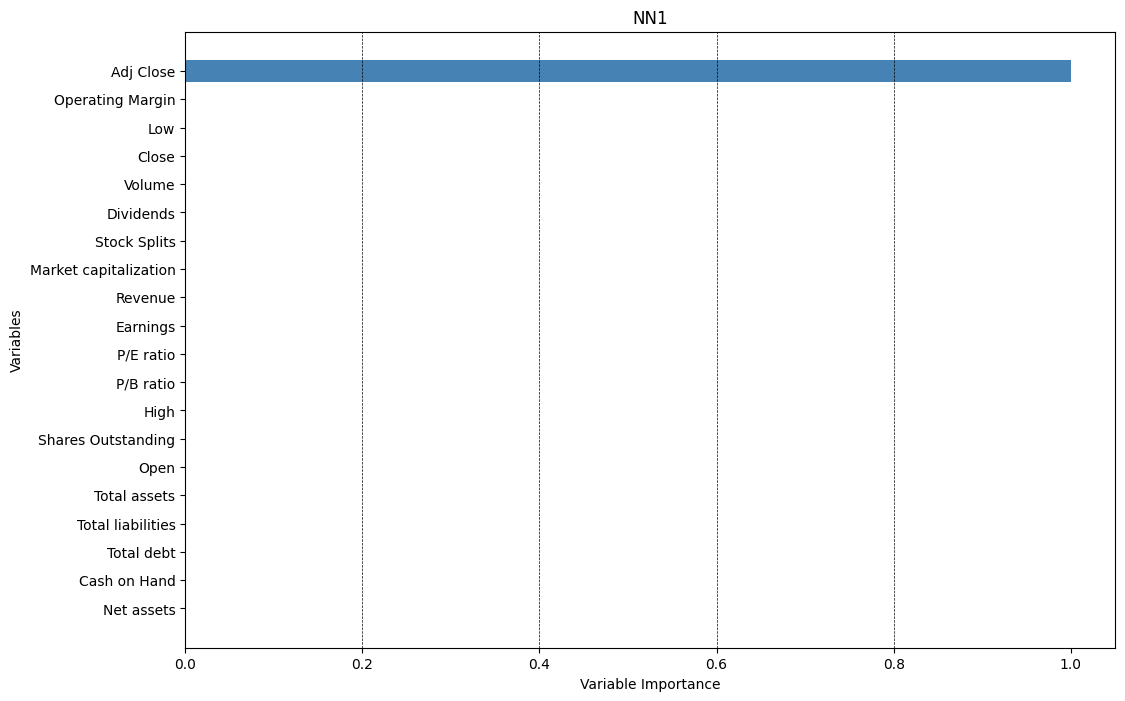

In [111]:
imp = varimp.sort_values('var_imp', ascending=False).head(20)

df_plot = pd.DataFrame({
    'Variable': imp['Variable'],
    'Importance': imp['var_imp']
})

plt.figure(figsize=(12, 8))
plt.barh(df_plot['Variable'], df_plot['Importance'], color='steelblue')
plt.gca().invert_yaxis()



plt.axvline(0.2, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.4, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.6, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0.8, color='black', linestyle='--', linewidth=0.5)



plt.xlabel('Variable Importance')
plt.ylabel('Variables')
plt.title('NN1')

plt.show()

In [112]:
varimp=varimp[["Variable", "var_imp"]]
varimp.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/variable-comparison/varimp NN1.csv', index = False)

# Preparations for machine learning portfolios

In [41]:
# The following is a table comparing the estimiates to the true values of each stock for every day in the test set.

# Remember to rerun df_final for all stock!

symbols = df_final.loc[dates_all.index, 'Symbol']  


comparison = pd.DataFrame({
    'Date': dates_all,  
    'y_hat': predictions_all.tolist(),
    'y_true': y_test_list_all.tolist(),
    'Symbol': symbols  
})


comparison['MonthYear'] = comparison['Date'].dt.to_period('M')

comparison = comparison.sort_values(by=['Date', 'Symbol'], ascending=True)
comparison = comparison.set_index(['MonthYear', 'Symbol'])

comparison

Date      y_hat     y_true
MonthYear Symbol                                 
2008-04   A      2008-04-30  19.211304  23.992857
          AAL    2008-04-30   6.848628   3.733256
          AAON   2008-04-30   3.166202   3.544210
          AAP    2008-04-30  31.150410  35.527317
          AAPL   2008-04-30   4.064268   5.692668
...                     ...        ...        ...
2024-08   ZVIA   2024-08-30   3.241525   1.020000
          ZVRA   2024-08-30   6.603068   7.390000
          ZWS    2024-08-30  30.096451  32.099998
          ZYME   2024-08-30  10.769750  12.100000
          ZYXI   2024-08-30   8.154094   7.960000

[510910 rows x 3 columns]

In [42]:
# Save the df for the Diebold-Mariano test

ols= comparison.reset_index()
ols.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN1 Estimates", index = False)

In [43]:
ols = pd.read_csv("C:/Users/CMert/Documents/Data bachelorprojekt/Estimater/NN1 Estimates")

Lad Adj Close være betegnet som P. Afkastraten udregnes ved:

$$ r_{t+1} = \frac{P_{t+1}}{P_t} -1 $$
Og

$$ \hat{r}_{t+1} = \frac{\hat{P}_{t+1}}{P_t} -1 $$

Merafkastsraten udregnes ved:

$$ er_{t+1} = r_{t+1} - r_{f,t+1}  $$
Og

$$ \hat{er}_{t+1} = \hat{r}_{t+1} - r_{f,t+1}  $$


Her er $R_{f,t}$ notation for den risikofrie rate i periode t. Fordi vi arbejder med amerikanske aktier, har vi fundet data for obligationsraten i USA, og benytter dette som den risikofrie rate.
Dataen er fundet her: https://fred.stlouisfed.org/series/DGS20

In [44]:
#Calculate estimiated future return, where distance between each period is one month. Notice that for the return estimate, then for P_t we use the actual adj close price, since at time t it is known: 

comparison = ols

comparison['Date'] = pd.to_datetime(comparison['Date'])


comparison = comparison.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)


comparison["ret_t+1_hat"] = comparison["y_hat"] / comparison.groupby("Symbol")["y_true"].shift(1) - 1
comparison["ret_t+1_true"] = comparison["y_true"] / comparison.groupby("Symbol")["y_true"].shift(1) - 1


comparison_ret_1m = comparison.sort_values(by=['Date', 'Symbol'], ascending=True)


comparison_ret_1m


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true
0,2008-04,A,2008-04-30,19.211304,23.992857,NaN,NaN
549,2008-04,AAL,2008-04-30,6.848628,3.733256,NaN,NaN
898,2008-04,AAON,2008-04-30,3.166202,3.544210,NaN,NaN
1095,2008-04,AAP,2008-04-30,31.150410,35.527317,NaN,NaN
1292,2008-04,AAPL,2008-04-30,4.064268,5.692668,NaN,NaN
...,...,...,...,...,...,...,...
510411,2024-08,ZVIA,2024-08-30,3.241525,1.020000,2.209431,0.009901
510510,2024-08,ZVRA,2024-08-30,6.603068,7.390000,-0.136854,-0.033987
510647,2024-08,ZWS,2024-08-30,30.096451,32.099998,-0.071957,-0.010176
510723,2024-08,ZYME,2024-08-30,10.769750,12.100000,-0.081863,0.031543


In [45]:
# Drop rows where either 'ret_t-(y_hat)	' or 'ret_t-(y_true)' is NaN
comparison_ret_1m = comparison_ret_1m.dropna(subset=['ret_t+1_hat', 'ret_t+1_true']).reset_index(drop=False)



In [46]:
treasury_securities = pd.read_excel("C:/Users/CMert/Documents/Data bachelorprojekt/Treasury securities.xlsx")

In [47]:
treasury_securities['Date'] = pd.to_datetime(treasury_securities['Date'])
comparison_ret_1m['Date'] = pd.to_datetime(comparison_ret_1m['Date'])

new_comparison = pd.merge(comparison_ret_1m, treasury_securities, on='Date', how='inner')

new_comparison = new_comparison[new_comparison['Treasury Securities'] != 0]

new_comparison['Treasury Securities'] = new_comparison['Treasury Securities'] / (12*100)

new_comparison['exc_ret_t+1_hat'] = new_comparison['ret_t+1_hat']-new_comparison['Treasury Securities']

new_comparison['exc_ret_t+1_true'] = new_comparison['ret_t+1_true']-new_comparison['Treasury Securities']

new_comparison = new_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

new_comparison = new_comparison.drop("index", axis = 1)

new_comparison


,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Treasury Securities,exc_ret_t+1_hat,exc_ret_t+1_true
0,2008-05,A,2008-05-30,23.160431,22.805721,-0.034695,-0.049479,0.003950,-0.038645,-0.053429
1,2008-05,AAL,2008-05-30,3.960641,2.356854,0.060908,-0.368687,0.003950,0.056958,-0.372637
2,2008-05,AAON,2008-05-30,3.553435,3.271587,0.002603,-0.076921,0.003950,-0.001347,-0.080871
3,2008-05,AAP,2008-05-30,35.490543,34.281311,-0.001035,-0.035072,0.003950,-0.004985,-0.039022
4,2008-05,AAPL,2008-05-30,4.895714,5.049963,-0.139997,-0.112901,0.003950,-0.143947,-0.116851
...,...,...,...,...,...,...,...,...,...,...
507062,2024-08,ZVIA,2024-08-30,3.241525,1.020000,2.209431,0.009901,0.003567,2.205864,0.006334
507063,2024-08,ZVRA,2024-08-30,6.603068,7.390000,-0.136854,-0.033987,0.003567,-0.140420,-0.037554
507064,2024-08,ZWS,2024-08-30,30.096451,32.099998,-0.071957,-0.010176,0.003567,-0.075523,-0.013742
507065,2024-08,ZYME,2024-08-30,10.769750,12.100000,-0.081863,0.031543,0.003567,-0.085429,0.027976


In [48]:
# Remember to rerun df_final, when adding 'Market cap' since it is standardized:

new_comparison['Date'] = pd.to_datetime(new_comparison['Date'])
df_final['Date'] = pd.to_datetime(df_final['Date'])

final_comparison = pd.merge(new_comparison, df_final[["Date", "Symbol", "Market capitalization"]], on=["Date", "Symbol"], how="inner")


final_comparison = final_comparison.sort_values(by=['Date', 'Symbol'], ascending=True)

In [49]:
final_comparison = final_comparison.rename(columns={'Treasury Securities' : 'Risk free rate'})

In [50]:
# We now limit the df to the following decade 2014-01 and 2023-12
final_comparison = final_comparison[
    (final_comparison["MonthYear"] >= "2014-01") &
    (final_comparison["MonthYear"] <= "2023-12")
]


In [51]:
final_comparison

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization
134848,2014-01,A,2014-01-31,38.292831,37.276997,0.005699,-0.020980,0.002792,0.002908,-0.023772,1.904000e+10
134849,2014-01,AACG,2014-01-31,0.627000,0.375884,0.793171,0.075000,0.002792,0.790380,0.072208,9.062000e+07
134850,2014-01,AAL,2014-01-31,33.275532,34.815441,0.052058,0.100745,0.002792,0.049267,0.097953,6.590000e+09
134851,2014-01,AAON,2014-01-31,12.996748,12.327587,0.062102,0.007418,0.002792,0.059310,0.004626,1.170000e+09
134852,2014-01,AAP,2014-01-31,106.445358,115.128609,0.025644,0.109311,0.002792,0.022853,0.106519,8.060000e+09
...,...,...,...,...,...,...,...,...,...,...,...
477000,2023-12,ZVIA,2023-12-29,2.916236,1.700000,0.450864,-0.154229,0.003500,0.447364,-0.157729,2.600000e+08
477001,2023-12,ZVRA,2023-12-29,5.394272,5.790000,-0.176447,-0.116031,0.003500,-0.179947,-0.119531,1.583091e+08
477002,2023-12,ZWS,2023-12-29,26.700895,29.427322,-0.085245,0.008160,0.003500,-0.088745,0.004660,3.760000e+09
477003,2023-12,ZYME,2023-12-29,9.475983,10.840000,-0.087971,0.043311,0.003500,-0.091471,0.039811,4.900000e+08


In [52]:
# Index every month in order

unique_months = final_comparison['MonthYear'].unique()
unique_months.sort()

month_indices = list(range(1, len(unique_months) + 1))

df_month_merge = pd.DataFrame({
    'MonthYear': unique_months,
    'MonthIndex': month_indices
})

final_comparison = final_comparison.merge(df_month_merge, on='MonthYear', how='left')


In [53]:
final_comparison

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization,MonthIndex
0,2014-01,A,2014-01-31,38.292831,37.276997,0.005699,-0.020980,0.002792,0.002908,-0.023772,1.904000e+10,1
1,2014-01,AACG,2014-01-31,0.627000,0.375884,0.793171,0.075000,0.002792,0.790380,0.072208,9.062000e+07,1
2,2014-01,AAL,2014-01-31,33.275532,34.815441,0.052058,0.100745,0.002792,0.049267,0.097953,6.590000e+09,1
3,2014-01,AAON,2014-01-31,12.996748,12.327587,0.062102,0.007418,0.002792,0.059310,0.004626,1.170000e+09,1
4,2014-01,AAP,2014-01-31,106.445358,115.128609,0.025644,0.109311,0.002792,0.022853,0.106519,8.060000e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...
342152,2023-12,ZVIA,2023-12-29,2.916236,1.700000,0.450864,-0.154229,0.003500,0.447364,-0.157729,2.600000e+08,120
342153,2023-12,ZVRA,2023-12-29,5.394272,5.790000,-0.176447,-0.116031,0.003500,-0.179947,-0.119531,1.583091e+08,120
342154,2023-12,ZWS,2023-12-29,26.700895,29.427322,-0.085245,0.008160,0.003500,-0.088745,0.004660,3.760000e+09,120
342155,2023-12,ZYME,2023-12-29,9.475983,10.840000,-0.087971,0.043311,0.003500,-0.091471,0.039811,4.900000e+08,120


In [54]:
# Function to add the decile rank of each stock in each month

def decile_ranks(df):
    df = df.sort_values(by='exc_ret_t+1_hat', ascending=True)
    
    df['Decile rank'] = pd.qcut(df['exc_ret_t+1_hat'], 10, labels=False, duplicates='drop')
    return df


final_comparison = final_comparison.groupby('MonthYear', group_keys=False).apply(decile_ranks)


In [55]:
# A dictionray of the stock history of each decile:

decile_dataframes = {}

# Loop through each decile rank
for decile in range(10):
    
    decile_df = final_comparison[final_comparison['Decile rank'] == decile].copy()
    
    decile_df.reset_index(drop=True, inplace=True)
    
    decile_dataframes[f'decile_rank_{decile}'] = decile_df

In [56]:
decile_dataframes['decile_rank_9']

,MonthYear,Symbol,Date,y_hat,y_true,ret_t+1_hat,ret_t+1_true,Risk free rate,exc_ret_t+1_hat,exc_ret_t+1_true,Market capitalization,MonthIndex,Decile rank
0,2014-01,MTRX,2014-01-31,27.852842,32.369999,0.059849,0.231735,0.002792,0.057058,0.228943,6.400000e+08,1,9
1,2014-01,MERC,2014-01-31,7.106480,6.266112,0.060044,-0.065310,0.002792,0.057252,-0.068102,5.500000e+08,1,9
2,2014-01,CENX,2014-01-31,12.371498,11.840000,0.060111,0.014567,0.002792,0.057320,0.011776,9.200000e+08,1,9
3,2014-01,DVAX,2014-01-31,18.457178,18.600000,0.060757,0.068966,0.002792,0.057966,0.066174,5.100000e+08,1,9
4,2014-01,WT,2014-01-31,11.837766,12.320658,0.060905,0.104182,0.002792,0.058113,0.101390,2.300000e+09,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34253,2023-12,KXIN,2023-12-29,47.390446,0.289000,52.852780,-0.671591,0.003500,52.849280,-0.675091,5.784000e+07,120,9
34254,2023-12,EAST,2023-12-29,135.479858,1.110000,104.023149,-0.139535,0.003500,104.019649,-0.143035,3.600000e+06,120,9
34255,2023-12,ONFO,2023-12-29,57.626072,0.540000,111.992300,0.058824,0.003500,111.988800,0.055324,7.760000e+06,120,9
34256,2023-12,ASNS,2023-12-29,141.391800,1.130000,125.242678,0.008929,0.003500,125.239178,0.005429,8.260000e+06,120,9


# Machine learning portfolios

For hvert decildatasæt og derfra for hver måned tilføjer vi to vægte for hver aktie. Vægtene er henholdsvis 'equal weights' og 'market capitalization weights' som udregnes ved:

$$w^{eq} = \frac{1}{N}, $$
hvor N er antallet af aktier for den respektive måned. Vægten baseret på aktiens markedsværdi udregnes ved:

$$w^{mc}_{i} = \frac{mc_i}{\sum_{j = 1}^N mc_j}, $$
hvor $i$ og $j$ er en indexering af aktierne for den respektive måned.

In [57]:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate eq weights:
    decile_dfs_value['eq_weights'] = 1 / decile_dfs_value.groupby('MonthYear')['Symbol'].transform('count')
    
    # Calculate mc weights
    decile_dfs_value['mc_weights'] = decile_dfs_value['Market capitalization'] / decile_dfs_value.groupby('MonthYear')['Market capitalization'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

I artiklen S. 2261 (PDF S. 39) er porteføljens merafkastsrate givet ved:

$$\hat{er}^P_{t+1} = \sum_{i = 1}^N w^P_{i,t} \cdot \hat{er}_{i,t+1} , $$
hvor P angiver den enkelte portefølje, specificeret ved variablerne Decile rank og MonthYear.

In [58]:
# Weighted true excess return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and excess return, to find the equal weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_true_eq'] = decile_dfs_value['exc_ret_t+1_true'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and excess return, to find the mc weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_true_mc'] = decile_dfs_value['exc_ret_t+1_true'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [59]:
# Weighted true portfolio excess return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio excess return:
    decile_dfs_value['portfolio_true_exc_ret_eq'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_true_eq'].transform('sum')
    
    # Calculate true mc portfolio excess return:
    decile_dfs_value['portfolio_true_exc_ret_mc'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_true_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [60]:
# Weighted predicted excess return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and excess return, to find the equal weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_hat_eq'] = decile_dfs_value['exc_ret_t+1_hat'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and excess return, to find the mc weighted excess return of each stock:
    decile_dfs_value['exc_ret_t+1_hat_mc'] = decile_dfs_value['exc_ret_t+1_hat'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [61]:
# Weighted predicted portfolio excess return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio excess return:
    decile_dfs_value['portfolio_hat_exc_ret_eq'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_hat_eq'].transform('sum')
    
    # Calculate true mc portfolio excess return:
    decile_dfs_value['portfolio_hat_exc_ret_mc'] = decile_dfs_value.groupby('MonthYear')['exc_ret_t+1_hat_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [62]:
# Weighted true return at t+1 for each stock:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    # Calculate the product of equal weights and return, to find the equal weighted return of each stock:
    decile_dfs_value['ret_t+1_true_eq'] = decile_dfs_value['ret_t+1_true'] * decile_dfs_value['eq_weights']
    
    
    # Calculate the product of mc weights and return, to find the mc weighted return of each stock:
    decile_dfs_value['ret_t+1_true_mc'] = decile_dfs_value['ret_t+1_true'] * decile_dfs_value['mc_weights']
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [63]:
# Weighted true portfolio return at t+1:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Calculate true eq portfolio return:
    decile_dfs_value['portfolio_true_ret_eq'] = decile_dfs_value.groupby('MonthYear')['ret_t+1_true_eq'].transform('sum')
    
    # Calculate true mc portfolio return:
    decile_dfs_value['portfolio_true_ret_mc'] = decile_dfs_value.groupby('MonthYear')['ret_t+1_true_mc'].transform('sum')
    
    decile_dataframes[decile_dfs_key] = decile_dfs_value

In [64]:
decile_dataframes['decile_rank_5'].columns

Index(['MonthYear', 'Symbol', 'Date', 'y_hat', 'y_true', 'ret_t+1_hat',
       'ret_t+1_true', 'Risk free rate', 'exc_ret_t+1_hat', 'exc_ret_t+1_true',
       'Market capitalization', 'MonthIndex', 'Decile rank', 'eq_weights',
       'mc_weights', 'exc_ret_t+1_true_eq', 'exc_ret_t+1_true_mc',
       'portfolio_true_exc_ret_eq', 'portfolio_true_exc_ret_mc',
       'exc_ret_t+1_hat_eq', 'exc_ret_t+1_hat_mc', 'portfolio_hat_exc_ret_eq',
       'portfolio_hat_exc_ret_mc', 'ret_t+1_true_eq', 'ret_t+1_true_mc',
       'portfolio_true_ret_eq', 'portfolio_true_ret_mc'],
      dtype='object')

In [65]:
portfolio_returns2 = {}

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():

    portfolio_variables = decile_dfs_value[['MonthYear',
                                   
                                   'portfolio_true_exc_ret_eq',
                                   'portfolio_true_exc_ret_mc',
                                   
                                   'portfolio_hat_exc_ret_eq',
                                   'portfolio_hat_exc_ret_mc',
                                   
                                   'portfolio_true_ret_eq',
                                   'portfolio_true_ret_mc',
                                   
                                   'Decile rank',
                                   'MonthIndex',
                                   
                                   ]].copy()
    
    portfolio_variables = portfolio_variables.drop_duplicates()
    
    portfolio_variables.reset_index(drop=True, inplace=True)
    
    portfolio_returns2[decile_dfs_key] = portfolio_variables


In [66]:
portfolio_returns2['decile_rank_9']

,MonthYear,portfolio_true_exc_ret_eq,portfolio_true_exc_ret_mc,portfolio_hat_exc_ret_eq,portfolio_hat_exc_ret_mc,portfolio_true_ret_eq,portfolio_true_ret_mc,Decile rank,MonthIndex
0,2014-01,0.117924,0.036918,0.171483,0.120994,0.120716,0.039710,9,1
1,2014-02,0.082619,0.041191,0.143614,0.116600,0.085377,0.043949,9,2
2,2014-03,0.023409,0.021562,0.133422,0.097268,0.026167,0.024320,9,3
3,2014-04,0.060316,0.041960,0.120494,0.118254,0.062999,0.044644,9,4
4,2014-05,0.099659,0.049784,0.136195,0.119256,0.102201,0.052325,9,5
...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.037885,0.000166,3.056373,1.321103,-0.034226,0.003824,9,116
116,2023-09,-0.117364,-0.047910,3.634799,1.446687,-0.113264,-0.043810,9,117
117,2023-10,0.176124,0.078924,4.830740,1.892665,0.180466,0.083266,9,118
118,2023-11,0.171903,0.079447,4.811416,1.888631,0.175837,0.083380,9,119


Pr. vores finansieringsbog, så gælder: "For any portfolio, P, we define the Sharpe-ratio as excess return relative to standard deviation", jf. S. 57, "Finance 1 and Beyond":

$$Sharpe-ratio^P = \frac{er^P_{t+1}}{\sigma_R^P}$$

In [67]:
#Find Sharpe-ratio of each decile rank dataframe:

for decile_key, portfolio_df in portfolio_returns2.items():
    
    # Calculate average of the true portfolio excess return
    mean_ER_true_eq = portfolio_df['portfolio_true_exc_ret_eq'].mean()
    mean_ER_true_mc = portfolio_df['portfolio_true_exc_ret_mc'].mean()
    
    # Calculate average of the predicted portfolio excess return
    mean_ER_pred_eq = portfolio_df['portfolio_hat_exc_ret_eq'].mean()
    mean_ER_pred_mc = portfolio_df['portfolio_hat_exc_ret_mc'].mean()
    
    # Calculate standard deviation of the true portfolio excess returns
    std_R_true_eq = portfolio_df['portfolio_true_ret_eq'].std()
    std_R_true_mc = portfolio_df['portfolio_true_ret_mc'].std()
    
    # Calculate annualized Sharpe ratio of the true excess returns
    sharpe_ratio_eq = (mean_ER_true_eq / std_R_true_eq) * np.sqrt(12)
    sharpe_ratio_mc = (mean_ER_true_mc / std_R_true_mc) * np.sqrt(12)
    
   
    portfolio_df['Mean_true_ER_eq'] = mean_ER_true_eq
    portfolio_df['Mean_true_ER_mc'] = mean_ER_true_mc
    portfolio_df['Mean_pred_ER_eq'] = mean_ER_pred_eq
    portfolio_df['Mean_pred_ER_mc'] = mean_ER_pred_mc
    portfolio_df['Std_true_ER_eq'] = std_R_true_eq
    portfolio_df['Std_true_ER_mc'] = std_R_true_mc
    portfolio_df['Sharpe_ratio_eq'] = sharpe_ratio_eq
    portfolio_df['Sharpe_ratio_mc'] = sharpe_ratio_mc
    

    portfolio_returns2[decile_key] = portfolio_df

# Zero-net-investment long-short portfolios

At shorte en aktie betyder at du låner aktier, som du vælger at sælge, fordi du forudsiger at de vil falde i pris og dermed kan du købe dem billiger og tjene differencen. At longe en aktie betyder at du køber en aktie, fordi du forventer den stiger i pris og dermed kan tjene differencen. Derfor vil man ifølge zero-net-investment teorien bruge alle ens penge på long-investment, hvor pengene kommer af de aktier man lige har shortet. Dvs. til tid 0 skal ens portefølje have følgende værdi:

$$\sum_{i = 1}^N w_i \cdot P^{long}_{i,0} - \sum_{j = 1}^M w_j \cdot P^{short}_{j,0} = 0$$
Her vælges vægtene for både short- og long-aktierne som før, hvor summen af alle vægte skal være 1. Afkastet for zero-net-investment er dermed til tid t givet ved:

$$\sum_{i = 1}^N w_i \cdot P^{long}_{i,t} - \sum_{j = 1}^M w_j \cdot P^{short}_{j,t} = profit$$

In [68]:
# Create the tables that show the performance of the machine learning portfolios

long_df = portfolio_returns2['decile_rank_9'].copy()
short_df = portfolio_returns2['decile_rank_0'].copy()

long_df['Investment type'] = 'long'
short_df['Investment type'] = 'short'


calc_df = pd.merge(long_df, short_df, on='MonthIndex', suffixes=('_long', '_short'))

In [69]:

# Calculate zero-net investment excess returns
calc_df['true_ER_zni_eq'] = calc_df['portfolio_true_exc_ret_eq_long'] - calc_df['portfolio_true_exc_ret_eq_short']
calc_df['true_ER_zni_mc'] = calc_df['portfolio_true_exc_ret_mc_long'] - calc_df['portfolio_true_exc_ret_mc_short']
calc_df['pred_ER_zni_eq'] = calc_df['portfolio_hat_exc_ret_eq_long'] - calc_df['portfolio_hat_exc_ret_eq_short']
calc_df['pred_ER_zni_mc'] = calc_df['portfolio_hat_exc_ret_mc_long'] - calc_df['portfolio_hat_exc_ret_mc_short']

# Calculate the means
mean_true_ER_zni_eq = calc_df['true_ER_zni_eq'].mean()
mean_true_ER_zni_mc = calc_df['true_ER_zni_mc'].mean()

mean_pred_ER_zni_eq = calc_df['pred_ER_zni_eq'].mean()
mean_pred_ER_zni_mc = calc_df['pred_ER_zni_mc'].mean()

# # Calculate zero-net investment returns that we need for Sharpe ratio
calc_df['true_R_zni_eq'] = calc_df['portfolio_true_ret_eq_long'] - calc_df['portfolio_true_ret_eq_short']
calc_df['true_R_zni_mc'] = calc_df['portfolio_true_ret_mc_long'] - calc_df['portfolio_true_ret_mc_short']


std_true_R_zni_eq = calc_df['true_R_zni_eq'].std()
std_true_R_zni_mc = calc_df['true_R_zni_mc'].std()

# Sharpe ratio
sharpe_ratio_eq_zni = (mean_true_ER_zni_eq / std_true_R_zni_eq) * np.sqrt(12)
sharpe_ratio_mc_zni = (mean_true_ER_zni_mc / std_true_R_zni_mc) * np.sqrt(12)




In [70]:
calc_df

,MonthYear_long,portfolio_true_exc_ret_eq_long,portfolio_true_exc_ret_mc_long,portfolio_hat_exc_ret_eq_long,portfolio_hat_exc_ret_mc_long,portfolio_true_ret_eq_long,portfolio_true_ret_mc_long,Decile rank_long,MonthIndex,Mean_true_ER_eq_long,...,Std_true_ER_mc_short,Sharpe_ratio_eq_short,Sharpe_ratio_mc_short,Investment type_short,true_ER_zni_eq,true_ER_zni_mc,pred_ER_zni_eq,pred_ER_zni_mc,true_R_zni_eq,true_R_zni_mc
0,2014-01,0.117924,0.036918,0.171483,0.120994,0.120716,0.039710,9,1,0.150878,...,0.064586,-2.469837,-1.433764,short,0.085592,0.012985,0.232033,0.163802,0.085592,0.012985
1,2014-02,0.082619,0.041191,0.143614,0.116600,0.085377,0.043949,9,2,0.150878,...,0.064586,-2.469837,-1.433764,short,0.147839,0.049206,0.214581,0.170624,0.147839,0.049206
2,2014-03,0.023409,0.021562,0.133422,0.097268,0.026167,0.024320,9,3,0.150878,...,0.064586,-2.469837,-1.433764,short,0.115101,0.012920,0.197320,0.153028,0.115101,0.012920
3,2014-04,0.060316,0.041960,0.120494,0.118254,0.062999,0.044644,9,4,0.150878,...,0.064586,-2.469837,-1.433764,short,0.104432,0.040115,0.183019,0.172505,0.104432,0.040115
4,2014-05,0.099659,0.049784,0.136195,0.119256,0.102201,0.052325,9,5,0.150878,...,0.064586,-2.469837,-1.433764,short,0.074939,0.030177,0.210450,0.174192,0.074939,0.030177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.037885,0.000166,3.056373,1.321103,-0.034226,0.003824,9,116,0.150878,...,0.064586,-2.469837,-1.433764,short,0.047341,0.024374,3.250677,1.499679,0.047342,0.024374
116,2023-09,-0.117364,-0.047910,3.634799,1.446687,-0.113264,-0.043810,9,117,0.150878,...,0.064586,-2.469837,-1.433764,short,-0.011217,0.008776,3.830289,1.623866,-0.011217,0.008776
117,2023-10,0.176124,0.078924,4.830740,1.892665,0.180466,0.083266,9,118,0.150878,...,0.064586,-2.469837,-1.433764,short,0.114351,0.000614,5.032969,2.072217,0.114351,0.000614
118,2023-11,0.171903,0.079447,4.811416,1.888631,0.175837,0.083380,9,119,0.150878,...,0.064586,-2.469837,-1.433764,short,0.090265,0.018201,5.020474,2.079574,0.090265,0.018201


In [71]:
performance_data = []

for i in range(10):
    decile_key = f'decile_rank_{i}'
    decile_df = portfolio_returns2[decile_key]
    
    mean_pred_ER_eq = decile_df['Mean_pred_ER_eq'].iloc[0]
    mean_true_ER_eq = decile_df['Mean_true_ER_eq'].iloc[0]
    std_true_ER_eq = decile_df['Std_true_ER_eq'].iloc[0]
    sharpe_ratio_eq = decile_df['Sharpe_ratio_eq'].iloc[0]
    
    performance_data.append([mean_pred_ER_eq, mean_true_ER_eq, std_true_ER_eq, sharpe_ratio_eq])

# The zero-net-investments caluclations will be used as H-L row
performance_data.append([mean_pred_ER_zni_eq, mean_true_ER_zni_eq, std_true_R_zni_eq, sharpe_ratio_eq_zni])


columns = ['Pred Avg', 'True Avg', 'SD', 'SR']
index = ['Low(L)', '1', '2', '3', '4', '5', '6', '7', '8', 'High(H)', 'H-L']

ML_performance_eq_table = pd.DataFrame(performance_data, columns=columns, index=index)



In [72]:
ML_performance_eq_table

,Pred Avg,True Avg,SD,SR
Low(L),-0.113464,-0.054605,0.076587,-2.469837
1,-0.054641,-0.027807,0.063100,-1.526570
2,-0.035896,-0.015049,0.055901,-0.932596
3,-0.022976,-0.005971,0.052426,-0.394546
4,-0.012149,0.001687,0.052043,0.112309
5,-0.002023,0.010326,0.051108,0.699870
6,0.008738,0.017700,0.051133,1.199112
7,0.022608,0.030322,0.058381,1.799208
8,0.060946,0.041373,0.066013,2.171088
High(H),2.898754,0.150878,0.422589,1.236796


In [73]:
performance_data = []

for i in range(10):
    decile_key = f'decile_rank_{i}'
    decile_df = portfolio_returns2[decile_key]
    
    mean_pred_ER_mc = decile_df['Mean_pred_ER_mc'].iloc[0]
    mean_true_ER_mc = decile_df['Mean_true_ER_mc'].iloc[0]
    std_true_ER_mc = decile_df['Std_true_ER_mc'].iloc[0]
    sharpe_ratio_mc = decile_df['Sharpe_ratio_mc'].iloc[0]
    
    performance_data.append([mean_pred_ER_mc, mean_true_ER_mc, std_true_ER_mc, sharpe_ratio_mc])

# The zero-net-investments caluclations will be used as H-L row
performance_data.append([mean_pred_ER_zni_mc, mean_true_ER_zni_mc, std_true_R_zni_mc, sharpe_ratio_mc_zni])

columns = ['Pred Avg', 'True Avg', 'SD', 'SR']
index = ['Low(L)', '1', '2', '3', '4', '5', '6', '7', '8', 'High(H)', 'H-L']

ML_performance_mc_table = pd.DataFrame(performance_data, columns=columns, index=index)

In [74]:
ML_performance_mc_table

,Pred Avg,True Avg,SD,SR
Low(L),-0.113376,-0.026731,0.064586,-1.433764
1,-0.054737,-0.017247,0.053641,-1.113775
2,-0.035862,-0.009660,0.046083,-0.726151
3,-0.022892,0.000515,0.045516,0.039230
4,-0.012125,0.005950,0.045157,0.456414
5,-0.002003,0.012630,0.045945,0.952287
6,0.008699,0.018433,0.045734,1.396210
7,0.022281,0.028005,0.048279,2.009440
8,0.055586,0.037524,0.056738,2.291029
High(H),0.368764,0.040129,0.065958,2.107562


In [75]:
ML_performance_eq_table.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN1_eq.csv")
ML_performance_mc_table.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML_Sharpe_results/NN1_mc.csv")

# The second table of the machine learning portfolios performance

Maximum drawdown er i artiklen defineret ved:

$$MaxDD = \max _{0 \leq t_{1} \leq t_{2} \leq T}\left(Y_{t_{1}}-Y_{t_{2}}\right),  $$
hvor $Y_t$ er den akkumulerede log afkast givet ved:

$$ r = \log\left(\prod_{i = 1}^{n}(1+r_i) \right)$$

$$ = \sum_{i = 1}^{n} \log \left( 1+r_i \right), $$
hvor n er antallet af porteføljer

In [76]:

# Calculate the maximum drawdown
def max_dd(returns):
    
    draw_downs = []
    exc_ret = returns.copy()
    
    # Calculate cumulative log excess returns
    exc_ret = np.log(1 + exc_ret).cumsum()
    
    
    peak = exc_ret.iloc[0]
    
    for i in range(1, len(exc_ret)):
        current = exc_ret.iloc[i]
        
        if current > peak:
            peak = current  
        else:
            drawdown = peak - current  
            draw_downs.append(drawdown)
    
    if draw_downs:
        max_drawdown = max(draw_downs)
    else:
        max_drawdown = 0  # In the off chance the stock is ever increasing
    
    return max_drawdown

maxdd_eq = max_dd(calc_df['true_ER_zni_eq'])
maxdd_mc = max_dd(calc_df['true_ER_zni_mc'])


maxdd_eq_pct = maxdd_eq * 100
maxdd_mc_pct = maxdd_mc * 100

print("MaxDD EQ: ", maxdd_eq_pct)
print("MaxDD MC: ", maxdd_mc_pct)

MaxDD EQ:  1.1280556014259702
MaxDD MC:  2.860869694679735


# Max 1M loss
I artiklen defineret som den mest extreme, negative månedlige afkast.

In [77]:
max_1m_loss_eq_pct = calc_df['true_ER_zni_eq'].min()*(-100)
max_1m_loss_mc_pct = calc_df['true_ER_zni_mc'].min()*(-100)

print("Max 1M EQ: ", max_1m_loss_eq_pct)
print("Max 1M MC: ", max_1m_loss_mc_pct)

Max 1M EQ:  1.1217169112650984
Max 1M MC:  2.8203342924504966


# Turnover

I artiklen er turnover defineret ved:

$$ \frac{1}{T} \sum_{t = 1}^T \left(\sum_{i = 1}^n   \bigg| w_{i,t+1} - \frac{w_{i,t}(1+r_{i,t+1})}{1+ \sum_{j = 1}^n  w_{j,t} \cdot r_{j,t+1}}  \bigg|  \right)  $$

In [78]:
# Get the t+1 weights for both eq and mc weights:

for decile_dfs_key, decile_dfs_value in decile_dataframes.items():
    
    decile_dfs_value.sort_values(['Symbol', 'MonthYear'], inplace=True)
    decile_dfs_value.reset_index(drop=True, inplace=True)
    
    # Create next month's weights for eq_weights and mc_weights, and if they dont exist set to 0
    decile_dfs_value['eq_weights_t+1'] = decile_dfs_value.groupby('Symbol')['eq_weights'].shift(-1).fillna(0)
    decile_dfs_value['mc_weights_t+1'] = decile_dfs_value.groupby('Symbol')['mc_weights'].shift(-1).fillna(0)

    
    decile_dataframes[decile_dfs_key] = decile_dfs_value


In [79]:
def turnover(long_df, short_df, weight_t0, weight_t1, exc_ret_t1):
    turnover_each_month = []
    
    # Combine long and short portfolios into one portfolio
    zero_net = pd.concat([long_df, short_df], ignore_index=True)
    
    zero_net.sort_values(['MonthYear'], inplace=True)
    zero_net.reset_index(drop=True, inplace=True)
    
    months = zero_net['MonthYear'].unique()
    
    for t in months[:-1]:  # Exclude the last month since it has no t+1 weights
        
        current_month = zero_net[zero_net['MonthYear'] == t]
        
        # Calculate the denominator for month t
        denominator = 1 + (current_month[weight_t0] * current_month[exc_ret_t1]).sum()
        
        # Calculate the turnover for each stock
        current_month['fraction'] = (
            current_month[weight_t0] * (1 + current_month[exc_ret_t1]) / denominator
        )
        current_month['abs_diff'] = abs(
            current_month[weight_t1] - current_month['fraction']
        )
        
        # Sum the absolute differences for month t
        turnover_each_month.append(current_month['abs_diff'].sum())
    
    # Calculate the average turnover across all months
    turnover = sum(turnover_each_month) / len(turnover_each_month)
    return turnover


In [80]:
long_df = decile_dataframes['decile_rank_9']
short_df = decile_dataframes['decile_rank_0']


weight_eq = 'eq_weights'
weight_t1_eq = 'eq_weights_t+1'
exc_ret_t1 = 'exc_ret_t+1_true'

turnover_eq = turnover(long_df, short_df, weight_eq, weight_t1_eq, exc_ret_t1)


weight_mc = 'mc_weights'
weight_t1_mc = 'mc_weights_t+1'
exc_ret_t1 = 'exc_ret_t+1_true'

turnover_mc = turnover(long_df, short_df, weight_mc, weight_t1_mc, exc_ret_t1)


turnover_eq_pct = turnover_eq*100
turnover_mc_pct = turnover_mc*100

print("Turnover EQ: ", turnover_eq_pct)
print("Turnover MC: ", turnover_mc_pct)


Turnover EQ:  48.10367696591407
Turnover MC:  74.57698877925671


In [82]:
eq_table_OLS = pd.DataFrame({
    "NN1" : [maxdd_eq_pct,
                max_1m_loss_eq_pct,
                turnover_eq_pct
                ]
})


eq_table_OLS.index = ['Max DD(%)', "Max 1M loss(%)", "Turnover(%)"]

In [83]:
eq_table_OLS

,NN1
Max DD(%),1.128056
Max 1M loss(%),1.121717
Turnover(%),48.103677


In [84]:
mc_table_OLS = pd.DataFrame({
    "NN1" : [maxdd_mc_pct,
                max_1m_loss_mc_pct,
                turnover_mc_pct
                ]
})


mc_table_OLS.index = ['Max DD(%)', "Max 1M loss(%)", "Turnover(%)"]

In [85]:
mc_table_OLS

,NN1
Max DD(%),2.860870
Max 1M loss(%),2.820334
Turnover(%),74.576989


In [86]:
eq_table_OLS.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML Performance tables/NN1_eq.csv")
mc_table_OLS.to_csv(r"C:/Users/CMert/Documents/Data bachelorprojekt/ML Performance tables/NN1_mc.csv")

# Cumulative log returns of portfolio rank 0 and 9

In [87]:
calc_df

,MonthYear_long,portfolio_true_exc_ret_eq_long,portfolio_true_exc_ret_mc_long,portfolio_hat_exc_ret_eq_long,portfolio_hat_exc_ret_mc_long,portfolio_true_ret_eq_long,portfolio_true_ret_mc_long,Decile rank_long,MonthIndex,Mean_true_ER_eq_long,...,Std_true_ER_mc_short,Sharpe_ratio_eq_short,Sharpe_ratio_mc_short,Investment type_short,true_ER_zni_eq,true_ER_zni_mc,pred_ER_zni_eq,pred_ER_zni_mc,true_R_zni_eq,true_R_zni_mc
0,2014-01,0.117924,0.036918,0.171483,0.120994,0.120716,0.039710,9,1,0.150878,...,0.064586,-2.469837,-1.433764,short,0.085592,0.012985,0.232033,0.163802,0.085592,0.012985
1,2014-02,0.082619,0.041191,0.143614,0.116600,0.085377,0.043949,9,2,0.150878,...,0.064586,-2.469837,-1.433764,short,0.147839,0.049206,0.214581,0.170624,0.147839,0.049206
2,2014-03,0.023409,0.021562,0.133422,0.097268,0.026167,0.024320,9,3,0.150878,...,0.064586,-2.469837,-1.433764,short,0.115101,0.012920,0.197320,0.153028,0.115101,0.012920
3,2014-04,0.060316,0.041960,0.120494,0.118254,0.062999,0.044644,9,4,0.150878,...,0.064586,-2.469837,-1.433764,short,0.104432,0.040115,0.183019,0.172505,0.104432,0.040115
4,2014-05,0.099659,0.049784,0.136195,0.119256,0.102201,0.052325,9,5,0.150878,...,0.064586,-2.469837,-1.433764,short,0.074939,0.030177,0.210450,0.174192,0.074939,0.030177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2023-08,-0.037885,0.000166,3.056373,1.321103,-0.034226,0.003824,9,116,0.150878,...,0.064586,-2.469837,-1.433764,short,0.047341,0.024374,3.250677,1.499679,0.047342,0.024374
116,2023-09,-0.117364,-0.047910,3.634799,1.446687,-0.113264,-0.043810,9,117,0.150878,...,0.064586,-2.469837,-1.433764,short,-0.011217,0.008776,3.830289,1.623866,-0.011217,0.008776
117,2023-10,0.176124,0.078924,4.830740,1.892665,0.180466,0.083266,9,118,0.150878,...,0.064586,-2.469837,-1.433764,short,0.114351,0.000614,5.032969,2.072217,0.114351,0.000614
118,2023-11,0.171903,0.079447,4.811416,1.888631,0.175837,0.083380,9,119,0.150878,...,0.064586,-2.469837,-1.433764,short,0.090265,0.018201,5.020474,2.079574,0.090265,0.018201


<Axes: xlabel='MonthYear_long'>

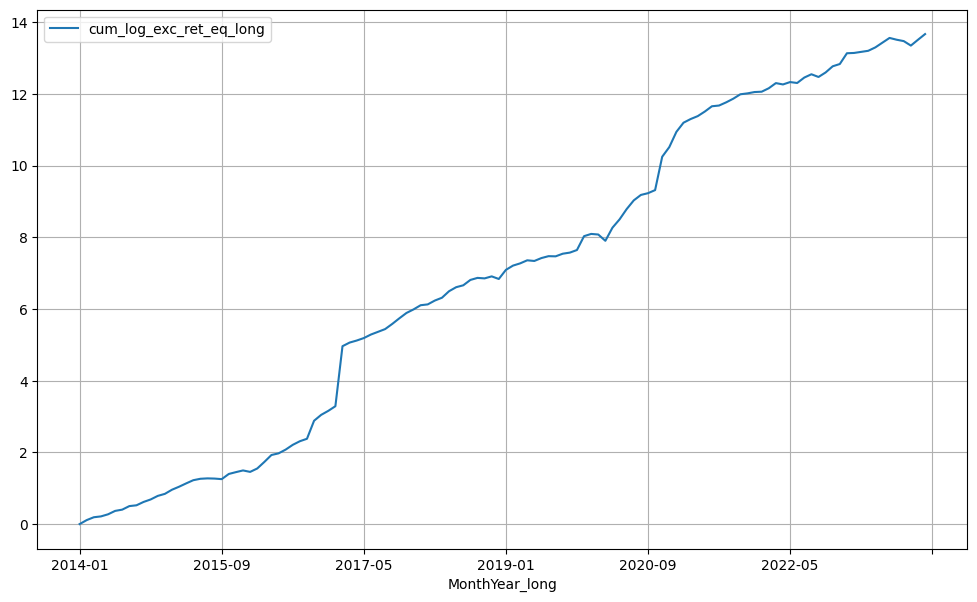

In [88]:
long_df = calc_df.copy()


long_df = long_df.set_index("MonthYear_long")
long_df.sort_values(['MonthYear_long'], inplace = True)


long_df['true_exc_ret_eq_t'] = long_df['portfolio_true_exc_ret_eq_long'].shift(1)


long_df['cum_log_exc_ret_eq_long'] =(np.log(1 + long_df['true_exc_ret_eq_t'])).cumsum()

long_df['cum_log_exc_ret_eq_long'].iloc[0] = 0


long_df[['cum_log_exc_ret_eq_long']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_long'>

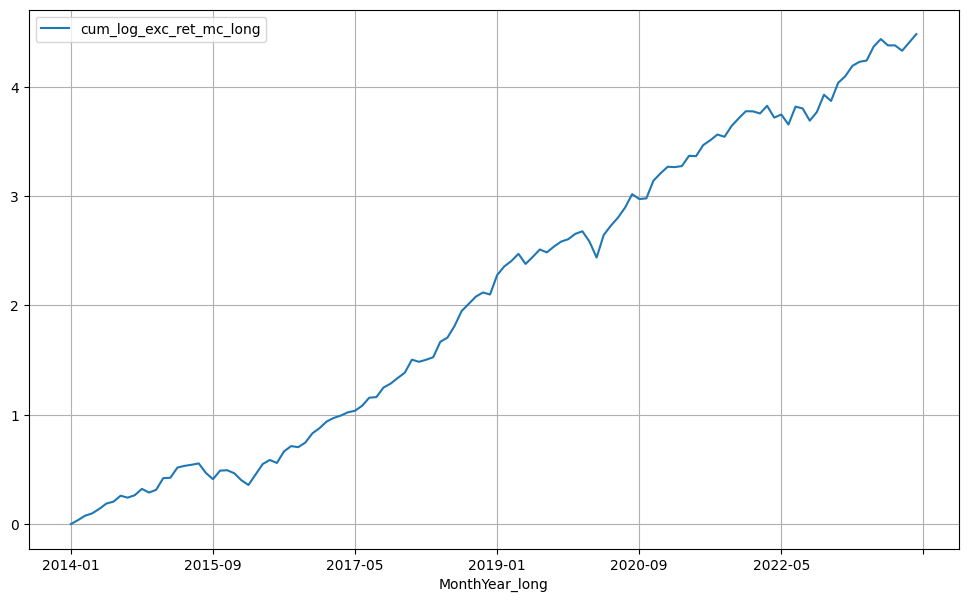

In [92]:
long_df = calc_df.copy()


long_df = long_df.set_index("MonthYear_long")
long_df.sort_values(['MonthYear_long'], inplace = True)


long_df['true_exc_ret_mc_t'] = long_df['portfolio_true_exc_ret_mc_long'].shift(1)


long_df['cum_log_exc_ret_mc_long'] =(np.log(1 + long_df['true_exc_ret_mc_t'])).cumsum()

long_df['cum_log_exc_ret_mc_long'].iloc[0] = 0

long_df[['cum_log_exc_ret_mc_long']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_short'>

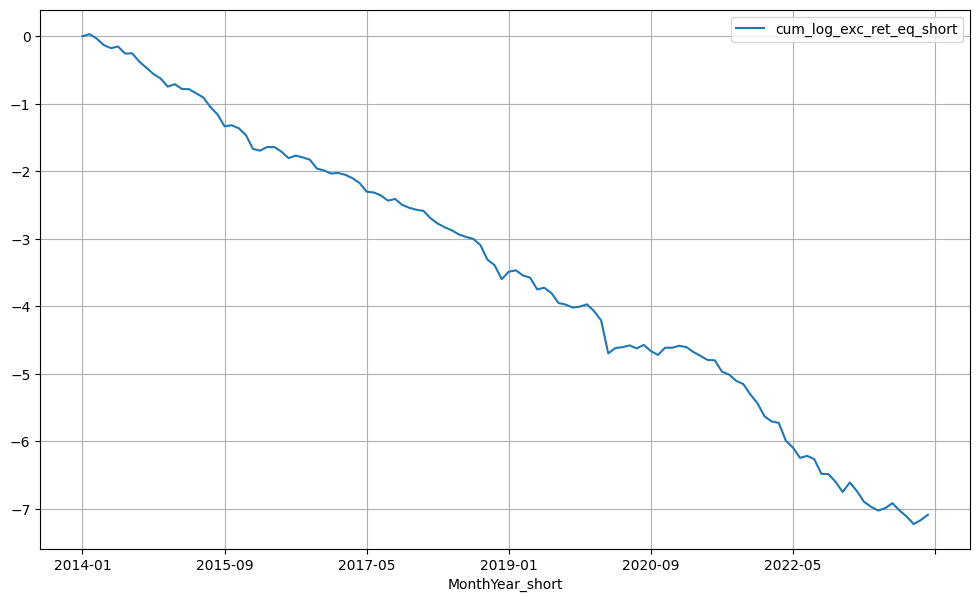

In [89]:
short_df = calc_df.copy()


short_df = long_df.set_index("MonthYear_short")
short_df.sort_values(['MonthYear_short'], inplace = True)


short_df['true_exc_ret_eq_t'] = short_df['portfolio_true_exc_ret_eq_short'].shift(1)


short_df['cum_log_exc_ret_eq_short'] = (np.log(1 + short_df['true_exc_ret_eq_t'])).cumsum()

short_df['cum_log_exc_ret_eq_short'].iloc[0] = 0


short_df[['cum_log_exc_ret_eq_short']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_short'>

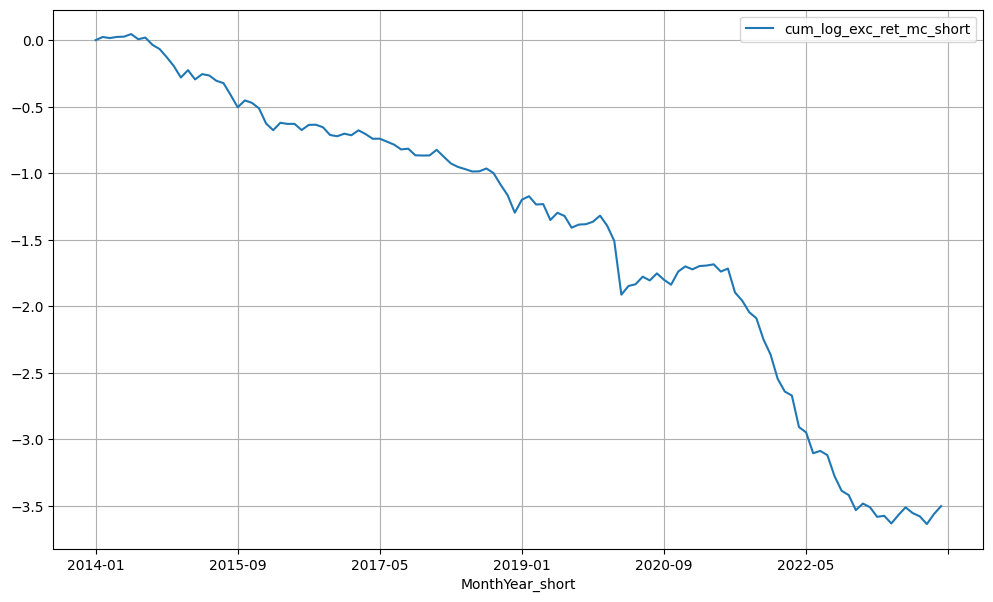

In [93]:
short_df = calc_df.copy()


short_df = long_df.set_index("MonthYear_short")
short_df.sort_values(['MonthYear_short'], inplace = True)


short_df['true_exc_ret_mc_t'] = short_df['portfolio_true_exc_ret_mc_short'].shift(1)


short_df['cum_log_exc_ret_mc_short'] = (np.log(1 + short_df['true_exc_ret_mc_t'])).cumsum()

short_df['cum_log_exc_ret_mc_short'].iloc[0] = 0


short_df[['cum_log_exc_ret_mc_short']].plot(grid=True, figsize=(12, 7))




<Axes: xlabel='MonthYear_long'>

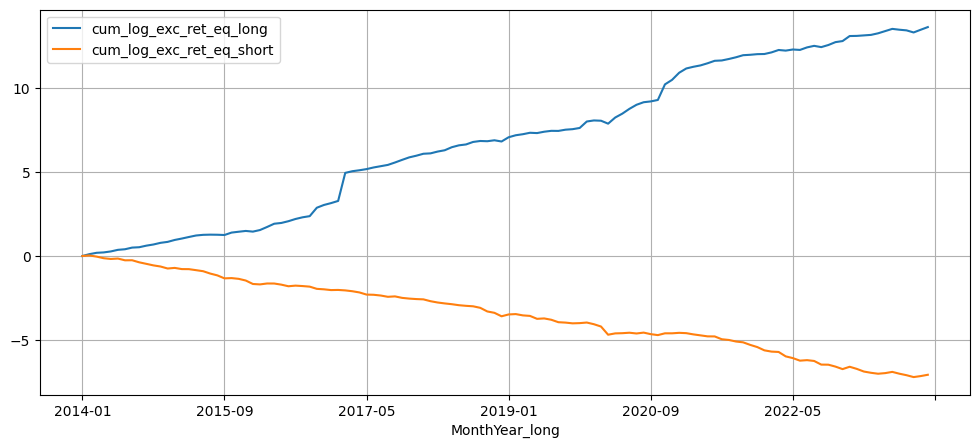

In [90]:
long_short_OLS_eq = pd.merge(long_df[['cum_log_exc_ret_eq_long']], short_df[['cum_log_exc_ret_eq_short']],left_index=True, right_index=True)


long_short_OLS_eq[["cum_log_exc_ret_eq_long", "cum_log_exc_ret_eq_short"]].plot(grid=True,figsize=(12, 5))

In [91]:
long_short_OLS_eq.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/NN1 eq.csv')

<Axes: xlabel='MonthYear_long'>

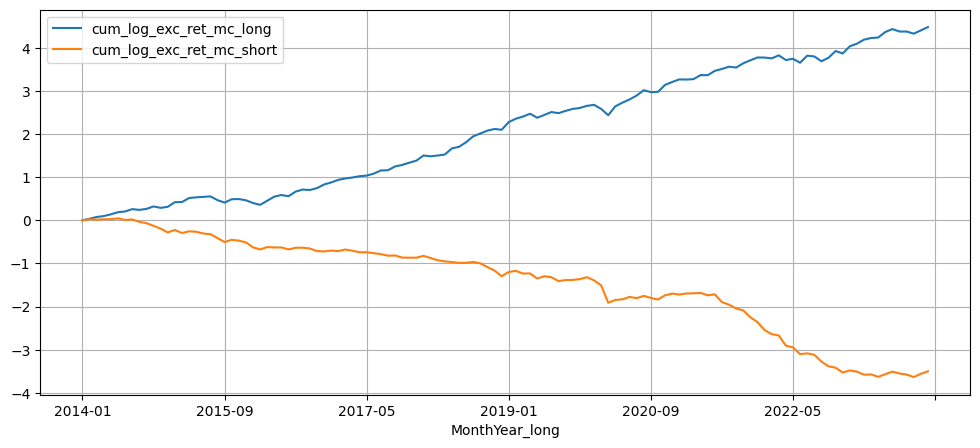

In [94]:

long_short_OLS_mc = pd.merge(long_df[['cum_log_exc_ret_mc_long']], short_df[['cum_log_exc_ret_mc_short']],left_index=True, right_index=True)


long_short_OLS_mc[["cum_log_exc_ret_mc_long", "cum_log_exc_ret_mc_short"]].plot(grid=True,figsize=(12, 5))

In [95]:
long_short_OLS_mc.to_csv(r'C:/Users/CMert/Documents/Data bachelorprojekt/ML grafer/NN1 mc.csv')

# Graveyard